## CNN Image Classifier - Transfer Learning
A highly effective approach to deep learning on small image datasets is to leverage a pre-trained network; this is referred to as tranfer learning. If the pre-trained model was trained on a dataset that is large enough and general enough, then the spatial feature hierarchy learned by the pre-trained network can effectively act as a generic model for your specific vision problem. The already learned features can prove useful for many different computer vision problems even though the new problems might involve completely different classes from those of the original model task. Portability of learned features across different problems is a key advantage of deep learning compared to older learning approaches and it makes deep learning very effective for small-data problems.

Here, we will utilize the VGG16 model that has been pre-trained on the ImageNet dataset to effectively turbo-boost our learning model. The ImageNet dataset contains 1.4 million labeled images and 1000 different classes.

In [1]:
# import libraries
import os
import numpy as np
from matplotlib import pyplot as plt
from PIL import Image as im
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.constraints import maxnorm
from keras.optimizers import RMSprop

Using TensorFlow backend.


In [2]:
# import and instantiate the VGG16 model
from keras.applications import VGG16
conv_base = VGG16(weights='imagenet', include_top=False, input_shape=(150, 150, 3))

We passed three arguments to the constructor:

1) weights, to specify which weight checkpoint to initialize the model

2) include_top, which refers to including or not the densely-connected classifier on top of the network. By default, this densely-connected classifier would correspond to the 1000 classes from ImageNet.

3) input_shape, the shape of the image tensors that we will feed to the network. This argument is purely optional: if we don't pass it, then the network will be able to process inputs of any size.


In [3]:
# review the VGG16 convolutional-base network architecture
conv_base.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0         
__________

In [4]:
# define dataset locations
base_dir = 'data/cats_and_dogs_small'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

In [5]:
# Create data generators for image files
# turn image files on disk into batches of pre-processed floating point tensors
# then normalize and utilize data augmentation of the dataset
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

# note that the validation data should never be augmented
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    # target directory
    train_dir,
    # resize images to 150x150
    target_size=(150,150),
    batch_size=20,
    # Since we will use binary_crossentropy loss, we need binary labels
    class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary')

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [6]:
# define CNN model
def cnn_model():
    model = Sequential()
    model.add(conv_base)
    model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    return model    

In [7]:
# create the CNN model
model = cnn_model()
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               2097408   
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 257       
Total params: 16,812,353
Trainable params: 16,812,353
Non-trainable params: 0
_________________________________________________________________


In [8]:
# Freeze the pre-trained network
# "Freezing" a layer or set of layers means preventing their weights from getting updated during training. 
# If we don't do this, then the representations that were previously learned by the convolutional network would 
# get modified during training
print('This is the number of trainable weights before freezing the conv base:', len(model.trainable_weights))
conv_base.trainable = False
print('This is the number of trainable weights after freezing the conv base:', len(model.trainable_weights))

This is the number of trainable weights before freezing the conv base: 30
This is the number of trainable weights after freezing the conv base: 4


In [9]:
# compile the model 
model.compile(loss='binary_crossentropy', optimizer=RMSprop(lr=2e-5), metrics=['acc'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               2097408   
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 257       
Total params: 16,812,353
Trainable params: 2,097,665
Non-trainable params: 14,714,688
_________________________________________________________________


In [10]:
# fit the model
history = model.fit_generator(train_generator, steps_per_epoch=100, epochs=30, validation_data=validation_generator, validation_steps=50)

Epoch 1/30
100/100 [==============================] - 459s 5s/step - loss: 0.5951 - acc: 0.6840 - val_loss: 0.4532 - val_acc: 0.8320
Epoch 2/30
100/100 [==============================] - 479s 5s/step - loss: 0.5046 - acc: 0.7570 - val_loss: 0.3833 - val_acc: 0.8580
Epoch 3/30
100/100 [==============================] - 928s 9s/step - loss: 0.4570 - acc: 0.7910 - val_loss: 0.3438 - val_acc: 0.8710
Epoch 4/30
100/100 [==============================] - 964s 10s/step - loss: 0.4278 - acc: 0.8035 - val_loss: 0.3075 - val_acc: 0.8810
Epoch 5/30
100/100 [==============================] - 721s 7s/step - loss: 0.4030 - acc: 0.8340 - val_loss: 0.3028 - val_acc: 0.8840
Epoch 6/30
100/100 [==============================] - 495s 5s/step - loss: 0.3893 - acc: 0.8275 - val_loss: 0.2879 - val_acc: 0.8900
Epoch 7/30
100/100 [==============================] - 491s 5s/step - loss: 0.3630 - acc: 0.8370 - val_loss: 0.2741 - val_acc: 0.8940
Epoch 8/30
100/100 [==============================] - 488s 5s/step -

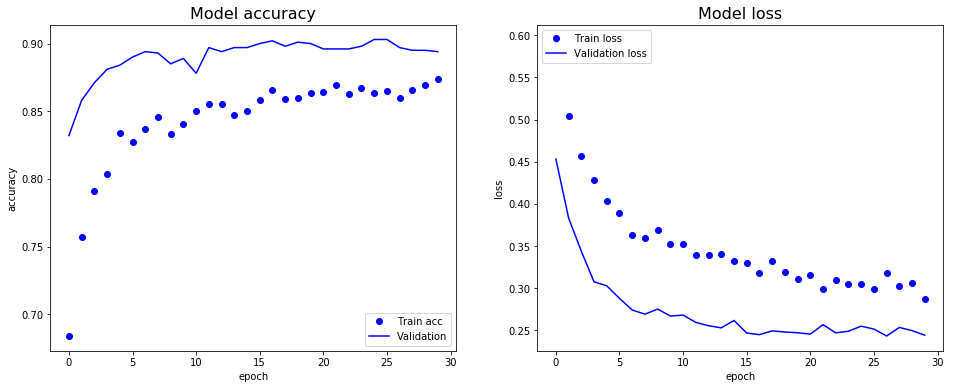

In [11]:
# plot the model loss and accuracy
fig, (axis1, axis2) = plt.subplots(nrows=1, ncols=2, figsize=(16,6))

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(acc))

# summarize history for accuracy
axis1.plot(epochs, acc, 'bo', label='Train acc')
axis1.plot(epochs, val_acc, 'b', label='Validation')
axis1.set_title('Model accuracy', fontsize=16)
axis1.set_ylabel('accuracy')
axis1.set_xlabel('epoch')
axis1.legend(loc='lower right')

# summarize history for loss
axis2.plot(epochs, loss, 'bo', label='Train loss')
axis2.plot(epochs, val_loss, 'b', label='Validation loss')
axis2.set_title('Model loss', fontsize=16)
axis2.set_ylabel('loss')
axis2.set_xlabel('epoch')
axis2.legend(loc='upper left')
plt.show()

In [12]:
# prep test data
test_dir = os.path.join(base_dir, 'test')
test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary')

Found 1000 images belonging to 2 classes.


In [13]:
# evaluate model on test data
score = model.evaluate_generator(test_generator, steps=50)
print("Accuracy: %.2f%%" % (score[1]*100))

Accuracy: 89.90%


In [14]:
# predict input image
def image_prediction(input_img):    
    prediction = model.predict(input_img)
    if prediction >= 0.5:
        print("The image is a dog!")
    else:
        print("The image is a cat!")

Shape of the input image tensor: (1, 150, 150, 3)


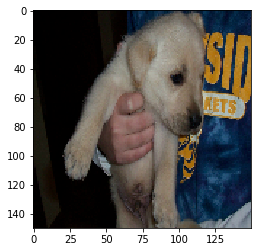

The image is a dog!


In [15]:
# test against new image
from keras.preprocessing import image

img_path = os.path.join(base_dir, 'baby_boom_2.jpg')
img = image.load_img(img_path, target_size=(150, 150))
img_tensor = image.img_to_array(img)
img_tensor = np.expand_dims(img_tensor, axis=0)
img_tensor /= 255.
print("Shape of the input image tensor:", img_tensor.shape)
plt.imshow(img_tensor[0])
plt.show()
image_prediction(img_tensor)

Shape of the input image tensor: (1, 150, 150, 3)


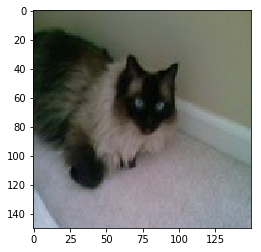

The image is a cat!


In [16]:
# test against another new image
img_path = os.path.join(base_dir, 'Stoops_010.jpg')
img = image.load_img(img_path, target_size=(150, 150))
img_tensor = image.img_to_array(img)
img_tensor = np.expand_dims(img_tensor, axis=0)
img_tensor /= 255.
print("Shape of the input image tensor:", img_tensor.shape)
plt.imshow(img_tensor[0])
plt.show()
image_prediction(img_tensor)

In [17]:
# save model and weights
model.save('dog_vs_cats_2.h5')
print("Model saved")
model.save_weights('dog_vs_cats_2_weights.h5')
print("Model weights saved")

Model saved
Model weights saved
